In [1]:
import numpy as np
from tqdm import tqdm
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

from model import AttentionModel
from dcascore import *
from utils import read_fasta_alignment, remove_duplicate_sequences
# back to original path (in PLM)
sys.path.pop(0)
from plm_gen_methods import generate_plm_n_save
from plm_seq_utils import nums_to_letters, modify_seq, letters_to_nums, set_seed, read_tensor_from_txt
from plm_hamming_dist import vectorized_hamming_distance
from plm_PCA_func import plot_pca_of_sequences

In [2]:
set_seed()
H = 64
d= 10
N = 174
n_epochs = 500
loss_type = 'without_J'
family = 'jdoms' #'jdoms_bacteria_train2'
#cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/my_project/PLM-gen-DCA/Attention-DCA-main/CODE/AttentionDCA_python/src'
cwd=r'C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\git_test\PLM-gen-DCA\Attention-DCA-main\CODE\AttentionDCA_python\src'

# Q_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/Q_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
# K_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/K_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
# V_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/V_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
Q_1 = read_tensor_from_txt( cwd +r'\results\{H}_{d}_{family}_{losstype}_{n_epochs}_youss\Q_tensor.txt'.format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
K_1 = read_tensor_from_txt( cwd +r'\results\{H}_{d}_{family}_{losstype}_{n_epochs}_youss\K_tensor.txt'.format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
V_1 = read_tensor_from_txt( cwd +r'\results\{H}_{d}_{family}_{losstype}_{n_epochs}_youss\V_tensor.txt'.format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
H,d,N=Q_1.shape
q=V_1.shape[1]

##############################################################
"""
    Initialize the model and compute couplings J from Q, K, V
""" 
model=AttentionModel(H,d,N,q,Q=Q_1,V=V_1,K=K_1)
torch.sum(model.Q-Q_1)
device = Q_1.device
L = Q_1.shape[-1]
W=attention_heads_from_model(model,Q_1,K_1,V_1)
print(W.shape)

i_indices = torch.arange(L, device=device).unsqueeze(1)
j_indices = torch.arange(L, device=device).unsqueeze(0)
mask = (i_indices != j_indices).float().unsqueeze(0)  # shape (1, L, L)
W = W * mask
    
# Compute Jtens
Jtens = torch.einsum('hri,hab->abri', W, V_1)  # Shape: (q, q, L, L)
q = Jtens.shape[0]
N = Jtens.shape[2]
print(q)
print(N)


beta_list=[5,2,0.5,0.1,0.01]


torch.Size([64, 63, 63])
21
63


<>:27: SyntaxWarning: invalid escape sequence '\C'
<>:27: SyntaxWarning: invalid escape sequence '\C'
C:\Users\youss\AppData\Local\Temp\ipykernel_12164\3376996822.py:27: SyntaxWarning: invalid escape sequence '\C'
  fig_file=cwd + f'\CODE\AttentionDCA_python\src\PLM\PCA_fig\PCA_beta_{beta}'


Total sequences read: 14502
Sequences after filtering: 14502
(63, 14502)
Removing duplicate sequences...
Done: 14502 -> 14502 sequences after removing duplicates.


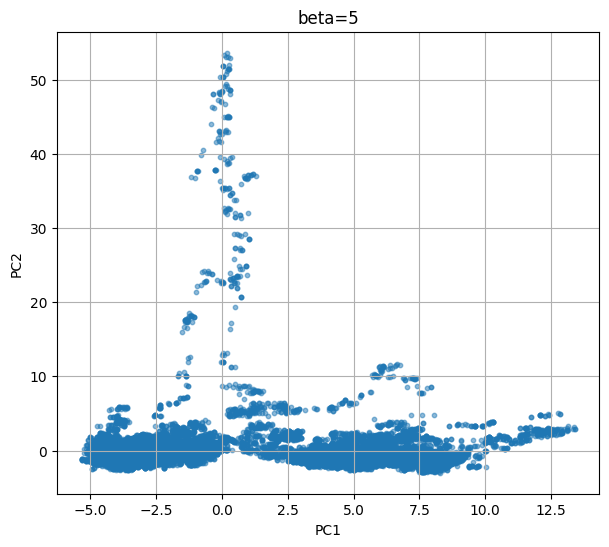

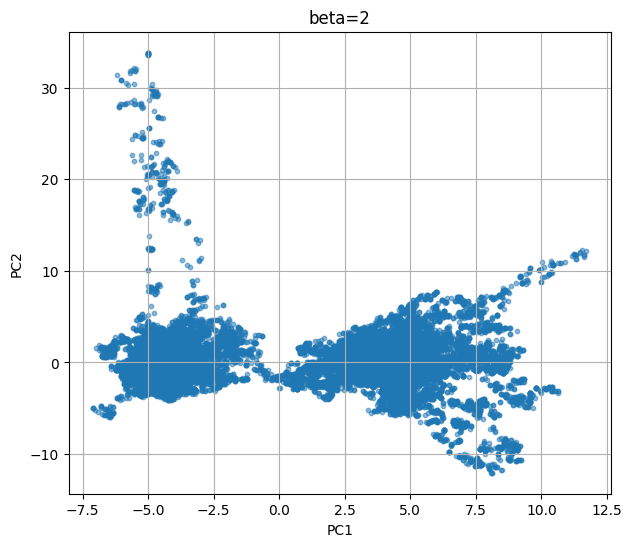

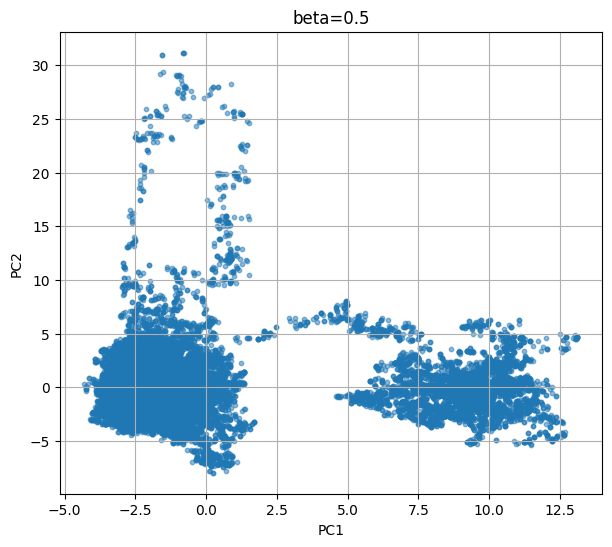

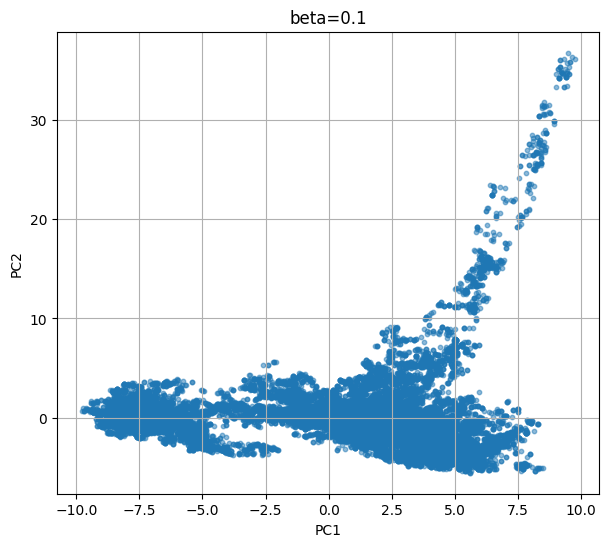

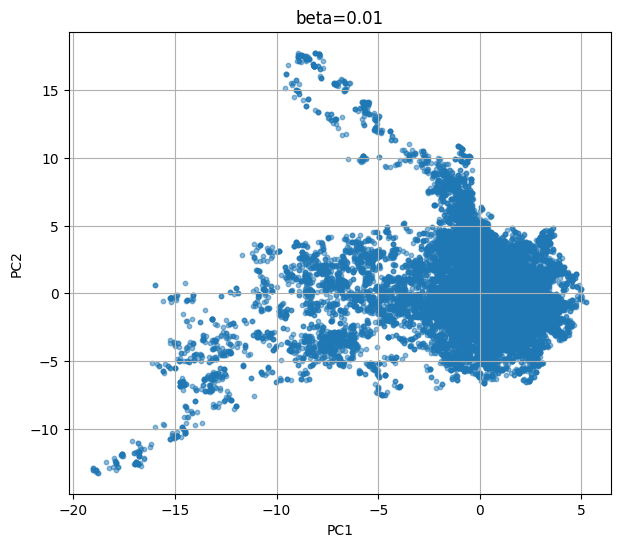

In [4]:
file_test_data=r"C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\git_test\PLM-gen-DCA\Attention-DCA-main\CODE\DataAttentionDCA\jdoms\jdoms_bacteria_train2.fasta"
seq_data_test=read_fasta_alignment(file_test_data,0.8)
mean_ham_dist=[]
print(seq_data_test.shape)
seq_data_test_filtered,_=remove_duplicate_sequences(seq_data_test)
seq_data_test_filtered=seq_data_test_filtered.T
for beta in beta_list:
    save_dir = "generated_sequences"
    N_seqs = 30000
    save_name = f"plm_generated_sequences_{N_seqs}_beta_{beta}"
    init_sequence = 'DYYQVLGVPKDADAKSIKKAFRKLARKYHPDVNPGDKEAERKFKEANEANEVLSDPEKRKKYD'
    init_sequence_num = letters_to_nums(init_sequence)
    ratio = 0.2
    init_sequence_num = modify_seq(init_sequence_num, ratio)
    #generate_plm_n_save(save_dir, save_name, Jtens, N_seqs, init_sequence=init_sequence_num,beta=beta)
    filename = save_name
    #filename = 'generated_sequences_randinit_40000'
    #filename = 'generated_sequences_10000'
    #cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/my_project/PLM-gen-DCA/Attention-DCA-main'
    cwd=r'C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\git_test\PLM-gen-DCA\Attention-DCA-main'
    # Load the generated sequences
    #output_file = cwd + f'/CODE/AttentionDCA_python/src/PLM/generated_sequences/{filename}.npy'

    output_file = cwd + r"\CODE\AttentionDCA_python\src\PLM\generated_sequences\\" +filename +".npy"
    gen_sequences = np.load(output_file)
    mean_ham_dist.append(np.mean(vectorized_hamming_distance(gen_sequences[10000:],seq_data_test_filtered)))
    fig_file=cwd + f'\CODE\AttentionDCA_python\src\PLM\PCA_fig\PCA_beta_{beta}'
    plot_pca_of_sequences(gen_sequences,title=f"beta={beta}")
    


    
